## Set up paths and imports

In [1]:
import os
if not os.path.exists("./notebooks"):
    %cd ..

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from src.log_reg_ccd import LogRegCCD

/home/mytkom/Documents/DataScience/AML/Projects/LogRegCCD


Test Accuracy: 0.7850
[-0.65652976  0.15632172  0.11658108  0.01497572 -0.04393323  0.70165036
  0.23843619  0.01782454 -0.17607136 -0.59386001  0.0488874  -0.12526246
  0.13507927 -1.47257194  0.05428862  0.0263293  -0.06190133  0.09561888
  0.32624163 -0.05957187]
Number of selected features: 20
Non-zero coefficients: [-0.65652976  0.15632172  0.11658108  0.01497572 -0.04393323  0.70165036
  0.23843619  0.01782454 -0.17607136 -0.59386001  0.0488874  -0.12526246
  0.13507927 -1.47257194  0.05428862  0.0263293  -0.06190133  0.09561888
  0.32624163 -0.05957187]
intercept: [-0.10369508]


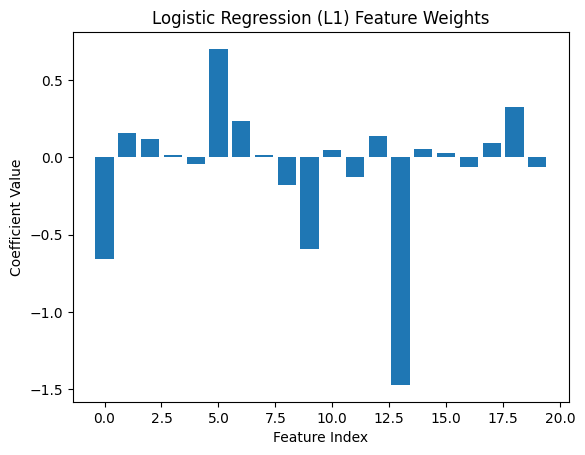

In [2]:
# Generate synthetic dataset
X, y = make_classification(
    n_samples=1000, n_features=20, n_informative=5, n_redundant=5, 
    n_classes=2, random_state=42
)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# Train Logistic Regression with L1 penalty (Lasso)
model = LogisticRegression(penalty='l1', solver='liblinear', C=1000)
model.fit(X_train, y_train)

# Predict and evaluate accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Display non-zero coefficients to check feature selection
coefficients = model.coef_.flatten()
print(coefficients)
num_selected_features = np.sum(coefficients != 0)

print(f"Number of selected features: {num_selected_features}")
print(f"Non-zero coefficients: {coefficients[coefficients != 0]}")
print(f"intercept: {model.intercept_}")

# Plot feature coefficients
plt.bar(range(len(coefficients)), coefficients)
plt.xlabel("Feature Index")
plt.ylabel("Coefficient Value")
plt.title("Logistic Regression (L1) Feature Weights")
plt.show()


In [5]:
import src.measures as measure

model = LogRegCCD(verbose=True)
model.fit(X_train, y_train, lam_max=10, lam_count=100)

# Predict and evaluate accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

model.validate(X_test, y_test, measure=measure.AUCROC())
model.validate(X_test, y_test, measure=measure.FMeasure())


LogRegCCD:  Number of features: 20
LogRegCCD:  Lambdas space: [1.00000000e+01 7.92482898e+00 6.28029144e+00 4.97702356e+00
 3.94420606e+00 3.12571585e+00 2.47707636e+00 1.96304065e+00
 1.55567614e+00 1.23284674e+00 9.77009957e-01 7.74263683e-01
 6.13590727e-01 4.86260158e-01 3.85352859e-01 3.05385551e-01
 2.42012826e-01 1.91791026e-01 1.51991108e-01 1.20450354e-01
 9.54548457e-02 7.56463328e-02 5.99484250e-02 4.75081016e-02
 3.76493581e-02 2.98364724e-02 2.36448941e-02 1.87381742e-02
 1.48496826e-02 1.17681195e-02 9.32603347e-03 7.39072203e-03
 5.85702082e-03 4.64158883e-03 3.67837977e-03 2.91505306e-03
 2.31012970e-03 1.83073828e-03 1.45082878e-03 1.14975700e-03
 9.11162756e-04 7.22080902e-04 5.72236766e-04 4.53487851e-04
 3.59381366e-04 2.84803587e-04 2.25701972e-04 1.78864953e-04
 1.41747416e-04 1.12332403e-04 8.90215085e-05 7.05480231e-05
 5.59081018e-05 4.43062146e-05 3.51119173e-05 2.78255940e-05
 2.20513074e-05 1.74752840e-05 1.38488637e-05 1.09749877e-05
 8.69749003e-06 6.89261